<a href="https://colab.research.google.com/github/chayan141/nlp-playlist/blob/main/langgraph_module_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streaming Interruption

human-in-the-loop : Allows users to interact directly with the graph.

In [ ]:
# %pip install -U langgraph langchain_openai langchain_core langchain_google_genai langgraph_sdk

In [ ]:
# !pip install -U langchain-google-genai

In [ ]:
from google.colab import userdata
gemini = userdata.get('gemini_api_key')
import os
os.environ['gemini_api_key'] = gemini

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [ ]:
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',api_key=gemini)

Note that we use RunnableConfig with call_model to enable token-wise streaming. This is only needed with python < 3.11. We include in case you are running this notebook in CoLab, which will use python 3.x.

In [ ]:
# State
class State(MessagesState):
    summary: str

In [ ]:
# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

In [ ]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [ ]:
# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

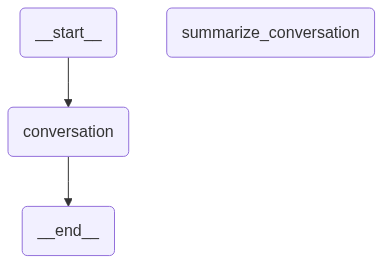

In [ ]:
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation,"summarize_conversation")

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Two Types of streaming:

values: This streams the full state of the graph after each node is called.

Updates: This streams updates to the state of the graph after each node is called. we only see updates to the state after node in the graph is run.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Lance! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--01110867-24d2-4a56-ac6e-f04fe650a8e8-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})}}


In [ ]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! It's good to meet you. What can I do for you today?


In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I help you today?
---------------------------------------------------------------------------


# Streaming Tokens

In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream.

In [ ]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='Alright', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--46110685-c79c-4734-a3cb-98cddaa6417d', usage_metadata={'input_tokens': 11, 'output_tokens': 0, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=", here's a breakdown of the San Francisco 49ers:\n\n**General", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--46110685-c79c-4734-a3cb-98cddaa6417d', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' Overview**\n\n*   **Team Name:** San Francisco 49ers (often', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--46110685-c79c-4734-a3cb-98cddaa6417d', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' shortened to 49ers or Niners)\n*  

# Breakpoints

For human-in-the-loop, we often want to see our graph outputs as its running.

Reason for Human-In-The-Loop:

1. Approval : We can interrupt our agent and allow user to approve an action.

2. Debugging : We can rewind the graph to reproduce or avoid issues.

3. Editing : You can modify the state.

Breakpoints : Simple way to stop the graph at specific step.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

Breakpoints for human approval : when we are concerned about tool use, We want to approve agents to use any of its tools.

All we need to do is simply compile the graph with **interrupt_before=["tools"]** where tools is our tools node.

This means that the execution will be interrupted before the node tools, which executes the tool call.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [ ]:
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',api_key=gemini)
llm_with_tools = model.bind_tools(tools)

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [ ]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [ ]:
# Graph
builder = StateGraph(MessagesState)

In [ ]:
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

In [ ]:
# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

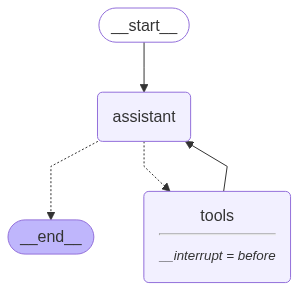

In [ ]:
memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b6ce31d7-0128-4852-a46e-fec6397a1bc7)
 Call ID: b6ce31d7-0128-4852-a46e-fec6397a1bc7
  Args:
    a: 2.0
    b: 3.0


In [ ]:
state = graph.get_state(thread)
state.next

('tools',)

When we invoke the graph with None, it will just continue from the last state checkpoint.

Graph : Control flow of nodes and edges.

Super-Steps: Each sequential node is a separate superstep where each parallel nodes shares same super step.

Checkpoints: State and relevent metadata packed at every super step.

Thread: Collection of checkpoints.

StateSnapshot : Type for checkpoint.

Graph.get_state() : Current checkpoint.

Graph.get_state_history() : List of all checkpoints.

Graph.stream(None, (thread_id)): Execute the graph from the current state.

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (b6ce31d7-0128-4852-a46e-fec6397a1bc7)
 Call ID: b6ce31d7-0128-4852-a46e-fec6397a1bc7
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## a specific user approval step that accepts user input.

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (2119fb0c-b331-4110-88ab-f914557da0cb)
 Call ID: 2119fb0c-b331-4110-88ab-f914557da0cb
  Args:
    a: 2.0
    b: 3.0


In [ ]:
# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":

    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("Operation cancelled by user.")

Do you want to call the tool? (yes/no): yes
================================== Ai Message ==================================
Tool Calls:
  multiply (2119fb0c-b331-4110-88ab-f914557da0cb)
 Call ID: 2119fb0c-b331-4110-88ab-f914557da0cb
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


# Dynamic BreakPoints

 sometimes it is helpful to allow the graph dynamically interrupt itself!

This is an internal breakpoint, and can be achieved using ***NodeInterrupt***

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the NodeInterrupt).

Nodeinterrupt is used inside a node.

In [ ]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

In [ ]:
class State(TypedDict):
    input: str

In [ ]:
def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

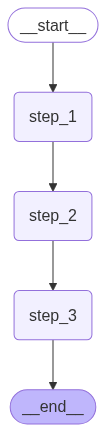

In [ ]:
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


In [ ]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the Interrupt is logged to state.

In [ ]:
print(state.tasks)

(PregelTask(id='6034c411-862f-13ae-866d-a1cc047e90e1', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None),), state=None, result=None),)


We can try to resume the graph from the breakpoint.

But, this just re-runs the same node!

Unless state is changed we will be stuck here.

In [ ]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [ ]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Updating the State

In [ ]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0530ab-52a6-6688-8002-3a389222a907'}}

In [ ]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


# Editing Graph State

Breakpoints are also opportunities to modify the graph state.

Let's set up our agent with a breakpoint before the assistant node.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',api_key=gemini)
llm_with_tools = model.bind_tools(tools)

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

In [ ]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

In [ ]:
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

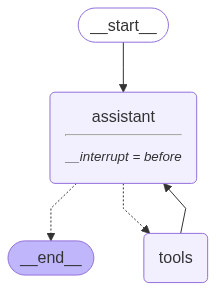

In [ ]:
memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='509ac2f5-6608-42a6-86c0-ef6439acaf44')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530bc-1f3c-6c28-8000-284c33ab2a1b'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-27T04:04:01.221104+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530bc-1f38-6a2a-bfff-566a7dba5726'}}, tasks=(PregelTask(id='96175aa7-9e0e-b6ed-72f0-2da36a34ee28', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, we can directly apply a state update.

Remember, updates to the messages key will use the add_messages reducer:

If we want to over-write the existing message, we can supply the message id.

If we simply want to append to our list of messages, then we can pass a message without an id specified, as shown below.

In [ ]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0530c0-6b31-6a0b-8001-716b479adba6'}}

Let's have a look.

We called update_state with a new message.

The add_messages reducer appends it to our state key, messages.

In [ ]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (ceb1ff12-fb4c-45fd-86aa-97a2fcd0a743)
 Call ID: ceb1ff12-fb4c-45fd-86aa-97a2fcd0a743
  Args:
    a: 3.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the assistant, which has our breakpoint.

We can again pass None to proceed.

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The answer is 9.


# Time Travel

Used for Debugging by viewing, re-playing and even forking from past states.

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',api_key=gemini)
llm_with_tools = model.bind_tools(tools)

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [ ]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [ ]:
# Graph
builder = StateGraph(MessagesState)

In [ ]:
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

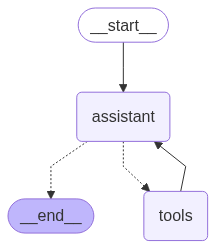

In [ ]:
memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (22a2f067-6741-4345-962c-6f75e98cd9ba)
 Call ID: 22a2f067-6741-4345-962c-6f75e98cd9ba
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Browsing History : We can use get_state to look at the current state of our graph, given the thread_id!.

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f8b76cbe-c10f-467a-8e8c-76370e170d85-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '22a2f067-6741-4345-962c-6f75e98cd9ba', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 'output_tokens': 5, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='6', name='multiply', id='d5eb6651-16c4-4197-b460-6c614f9a9bd1', tool_call_id='22a2f067-6741-4345-962c-6f75e98cd9ba'), AIMessage(content='The result of multiplying 2 and 3 is 6.', additional_kwargs={}, response_metadata={'prompt_feed

We can also browse the state history of our agent.

get_state_history lets us get the state at all prior steps.

In [ ]:
all_states = [s for s in graph.get_state_history(thread)]

In [ ]:
len(all_states)

5

In [ ]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530d8-5aea-658a-8000-f7217698ea3c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-27T04:16:39.098080+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530d8-5ae6-6241-bfff-a278405ed125'}}, tasks=(PregelTask(id='dd001367-f2b3-0dbd-45c6-61edc4f1b4b9', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safet

In [ ]:
l = [1,2,3,4,5]

In [ ]:
l[-2]

4

We can re-run our agent from any of the prior steps.

Let's look back at the step that recieved human input!

In [ ]:
to_replay = all_states[-2]

In [ ]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684')]}

We can see the next node to call.

In [ ]:
to_replay.next

('assistant',)

We also get the config, which tells us the checkpoint_id as well as the thread_id.

In [ ]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0530d8-5aea-658a-8000-f7217698ea3c'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [ ]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (1fdfd5d6-2b8c-41fb-ba67-3194361d5e23)
 Call ID: 1fdfd5d6-2b8c-41fb-ba67-3194361d5e23
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


# Forking

If we want to run from that same step but with a different input, this is called forking.

In [ ]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684')]

In [ ]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0530d8-5aea-658a-8000-f7217698ea3c'}}

Let's modify the state at this checkpoint.

We can just run update_state with the checkpoint_id supplied.

Remember how our reducer on messages works:

It will append, unless we supply a message ID.

We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have

to_fork.values["messages"].id.

In [ ]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

In [ ]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0530f8-668d-62f9-8001-e995af0c4d27'}}

his creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [ ]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684')]

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530f8-668d-62f9-8001-e995af0c4d27'}}, metadata={'source': 'update', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-27T04:30:59.311674+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0530d8-5aea-658a-8000-f7217698ea3c'}}, tasks=(PregelTask(id='599fc5a7-5bff-c81a-07bd-6c63897109c4', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (12fd0211-4fa9-4717-a47f-cd387005fc18)
 Call ID: 12fd0211-4fa9-4717-a47f-cd387005fc18
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='b4940f98-9b54-41d3-91c2-ea0c39261684'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 5.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c9beb688-2488-4f9e-819e-84fe04a2b81a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5.0, 'b': 3.0}, 'id': '12fd0211-4fa9-4717-a47f-cd387005fc18', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 'output_tokens': 5, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='15', name='multiply', id='9ddb22db-602e-4a6b-b1df-555a419d2ea4', tool_call_id='12fd0211-4fa9-4717-a47f-cd387005fc18'), AIMessage(content='The result of multiplying 5 and 3 is 15.', additional_kwargs={}, response_metadata={'prompt_fe